Get emails and labels + split

In [6]:
import glob
import os
corpus_path = 'C:/Users/Rik/Documents/corpus/'
emails, labels = [], []
def readFilesForFolder(folder_path, is_spam):
    file_path = corpus_path + 'enron1/' + folder_path
    for filename in glob.glob(os.path.join(file_path, '*.txt')):
        with open(filename, 'r', encoding="ISO-8859-1") as infile:
            emails.append(infile.read())
            labels.append(is_spam)
readFilesForFolder('spam', 1)
print(len(emails))
print(len(labels))
readFilesForFolder('ham', 0)
print(len(emails))
print(len(labels))

from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
def is_letter_only(word):
    return word.isalpha()
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()
def clean_text(docs):
    docs_cleaned = []
    for doc in docs:
        doc = doc.lower()
        doc_cleaned = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if is_letter_only(word))
        docs_cleaned.append(doc_cleaned)
    return docs_cleaned
emails_cleaned= clean_text(emails)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(emails_cleaned, labels, test_size=0.33, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

pos_test_count = len(list(filter(lambda x: x == 1, Y_test)))
print("Pos test count", pos_test_count)
neg_test_count = len(list(filter(lambda x: x == 0, Y_test)))
print("Neg test count", neg_test_count)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english", max_features=1000, max_df=0.5, min_df=2)

term_docs_train = cv.fit_transform(X_train)
term_docs_test = cv.transform(X_test)

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(term_docs_train, Y_train)

prediction = clf.predict(term_docs_test)

1500
1500
5172
5172
3465 3465
1707 1707
Pos test count 516
Neg test count 1191


In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction, labels=[0, 1])

array([[1102,   89],
       [  31,  485]], dtype=int64)

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('precision')
print(precision_score(Y_test, prediction, pos_label=1))

print('recall')
print(recall_score(Y_test, prediction, pos_label=1))

print('f1 score')
print(f1_score(Y_test, prediction, pos_label=1))

precision
0.8449477351916377
recall
0.939922480620155
f1 score
0.889908256880734


In [9]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1191
           1       0.84      0.94      0.89       516

    accuracy                           0.93      1707
   macro avg       0.91      0.93      0.92      1707
weighted avg       0.93      0.93      0.93      1707



Creating the ROC curve

In [34]:
import numpy as np

# get predicted probability for the test set
prediction_prob = clf.predict_proba(term_docs_test)
# get positive probability
pos_prob = prediction_prob[:, 1]
# set up tresholds from 0.0 to 1.0
tresholds = np.arange(0.0, 1.2, 0.1)
# create empty arrays for true positive and false positive count for each treshold
true_pos, false_pos = [0] * len(tresholds), [0] * len(tresholds)
# loop over positive probability along with equivalent Y_test result
for pred, y in zip(pos_prob, Y_test):
    # loop over tresholds
    for i, treshold in enumerate(tresholds):
        if pred >= treshold:
            # if truth and predication are both 1
            if y == 1:
                true_pos[i] += 1
            # if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break
# calculate true pos rate and false pos rate for each treshold
true_pos_rate = [tp / pos_test_count for tp in true_pos]
false_pos_rate = [fp / neg_test_count for fp in false_pos]

No handles with labels found to put in legend.


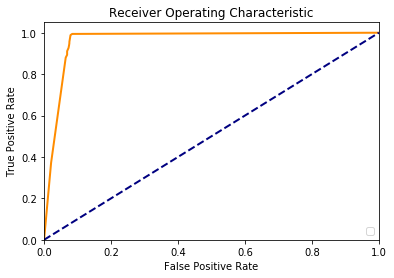

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.965361984912685